In [1]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import CuDNNGRU
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Lambda
from keras.layers import Dropout
from keras.layers import SimpleRNN
from keras.utils import generic_utils
from keras.utils import Sequence
from keras import regularizers
from keras import optimizers
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
import sys
import feather
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)
np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.


In [2]:
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments


In [3]:
# set up training set
view_1hot_df = feather.read_dataframe("/home/whsu014/data/view_1hot_nona_len29_float_age_impute_and_True_HG_100096inds.feather")
print(view_1hot_df.columns)
print(view_1hot_df.shape)

print(view_1hot_df['CVD_ISOSORBRIDE_DINITRATE'].unique())
view_1hot_df = view_1hot_df.drop(['CVD_ISOSORBRIDE_DINITRATE'], axis=1)
print(view_1hot_df.shape)
print("Number of inds:", len(view_1hot_df['VSIMPLE_INDEX_MASTER'].unique()))
# set length to 28
print(view_1hot_df.shape[0]/29)
view_1hot_df = copy.deepcopy(view_1hot_df[view_1hot_df['QUARTER']!=0])
print(view_1hot_df.shape[0]/28)
# Take 90000 inds for train and validation set
# remove true values
# remove QUARTER
view_1hot_df = view_1hot_df.drop(['QUARTER'], axis=1)
train_v = copy.deepcopy(view_1hot_df.iloc[:(28*90000), :-7].values)
print(train_v.shape)
print(train_v.shape[0]/28)

# set up test set
test_df = feather.read_dataframe("/home/whsu014/data/Test_set_with_TRUE_10096inds.feather")
print(test_df.columns)
print(test_df.shape)
print("Number of inds:", len(test_df['VSIMPLE_INDEX_MASTER'].unique()))
test_v = copy.deepcopy(test_df.iloc[:, :-7].values)

Index(['VSIMPLE_INDEX_MASTER', 'QUARTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1',
       'ETHN_2', 'ETHN_3', 'ETHN_4', 'ETHN_5',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=191)
(2902784, 191)
[0.]
(2902784, 190)
Number of inds: 100096
100096.0
100096.0
(2520000, 182)
90000.0
Index(['VSIMPLE_INDEX_MASTER', 'AGE', 'SEX', 'NZDEP', 'ETHN_1', 'ETHN_2',
       'ETHN_3', 'ETHN_4', 'ETHN_5', 'TEST',
       ...
       'PT_DIABETES_YR', 'PT_ATRIAL_FIBRILLATION', 'PT_IMP_FATAL_CVD',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL',
       'TRUE_HBA1C', 'TRUE_EGFR'],
      dtype='object', length=189)
(282688, 189)
Number of inds: 10096


In [4]:
print(train_v.shape)
print(test_v.shape)

(2520000, 182)
(282688, 182)


In [5]:
# standardise data
# z = (X - u)/s
# u is the mean of the training samples
# s is the standard devidation of the training samples
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_v) 
scaled_test = scaler.transform(test_v)

In [6]:
print('TCHDL:', view_1hot_df.columns.get_loc('TCHDL'))
print('TRUE_TCHDL:', view_1hot_df.columns.get_loc('TRUE_TCHDL'))

TCHDL: 14
TRUE_TCHDL: 186


In [7]:
def setup_xy(time_series):
    num_of_inds = time_series.shape[0]//28
    print("Number of individuals: ", num_of_inds)
    x_list = []
    y_list = []
    for i in range(num_of_inds): #num_of_inds[]
        ind_v = copy.deepcopy(time_series[(i*28):((i+1)*28), :])
        ind_x = copy.deepcopy(ind_v[:8, :]) 
        x_list.append(ind_x)
        y_list.append(np.array([ind_v[8:, 14]]).T) 
    x_v = np.array(x_list)
    y_v = np.array(y_list)
    return x_v, y_v 

In [8]:
x_train, y_train = setup_xy(scaled_train)
x_test, y_test = setup_xy(scaled_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Number of individuals:  90000
Number of individuals:  10096
(90000, 8, 182)
(90000, 20, 1)
(10096, 8, 182)
(10096, 20, 1)


9000
End: 36000
Train on 54000 samples, validate on 36000 samples
Epoch 1/200
 - 2s - loss: 0.9814 - val_loss: 0.6151

Epoch 00001: val_loss improved from inf to 0.61514, saving model to val_weights4.hdf5
Epoch 2/200
 - 1s - loss: 0.5383 - val_loss: 0.4947

Epoch 00002: val_loss improved from 0.61514 to 0.49467, saving model to val_weights4.hdf5
Epoch 3/200
 - 1s - loss: 0.4838 - val_loss: 0.4738

Epoch 00003: val_loss improved from 0.49467 to 0.47382, saving model to val_weights4.hdf5
Epoch 4/200
 - 1s - loss: 0.4701 - val_loss: 0.4647

Epoch 00004: val_loss improved from 0.47382 to 0.46467, saving model to val_weights4.hdf5
Epoch 5/200
 - 1s - loss: 0.4632 - val_loss: 0.4594

Epoch 00005: val_loss improved from 0.46467 to 0.45940, saving model to val_weights4.hdf5
Epoch 6/200
 - 1s - loss: 0.4589 - val_loss: 0.4552

Epoch 00006: val_loss improved from 0.45940 to 0.45520, saving model to val_weights4.hdf5
Epoch 7/200
 - 1s - loss: 0.4555 - val_loss: 0.4523

Epoch 00007: val_loss impro

 - 1s - loss: 0.4348 - val_loss: 0.4424

Epoch 00067: val_loss did not improve from 0.44236
Epoch 68/200
 - 1s - loss: 0.4340 - val_loss: 0.4426

Epoch 00068: val_loss did not improve from 0.44236
Epoch 69/200
 - 1s - loss: 0.4339 - val_loss: 0.4416

Epoch 00069: val_loss improved from 0.44236 to 0.44160, saving model to val_weights4.hdf5
Epoch 70/200
 - 1s - loss: 0.4339 - val_loss: 0.4427

Epoch 00070: val_loss did not improve from 0.44160
Epoch 71/200
 - 1s - loss: 0.4337 - val_loss: 0.4431

Epoch 00071: val_loss did not improve from 0.44160
Epoch 72/200
 - 1s - loss: 0.4336 - val_loss: 0.4427

Epoch 00072: val_loss did not improve from 0.44160
Epoch 73/200
 - 1s - loss: 0.4337 - val_loss: 0.4425

Epoch 00073: val_loss did not improve from 0.44160
Epoch 74/200
 - 1s - loss: 0.4334 - val_loss: 0.4431

Epoch 00074: val_loss did not improve from 0.44160
Epoch 75/200
 - 1s - loss: 0.4339 - val_loss: 0.4425

Epoch 00075: val_loss did not improve from 0.44160
Epoch 76/200
 - 1s - loss: 0.

 - 1s - loss: 0.4306 - val_loss: 0.4410

Epoch 00143: val_loss did not improve from 0.44023
Epoch 144/200
 - 1s - loss: 0.4305 - val_loss: 0.4422

Epoch 00144: val_loss did not improve from 0.44023
Epoch 145/200
 - 1s - loss: 0.4305 - val_loss: 0.4426

Epoch 00145: val_loss did not improve from 0.44023
Epoch 146/200
 - 1s - loss: 0.4300 - val_loss: 0.4417

Epoch 00146: val_loss did not improve from 0.44023
Epoch 147/200
 - 1s - loss: 0.4300 - val_loss: 0.4412

Epoch 00147: val_loss did not improve from 0.44023
Epoch 148/200
 - 1s - loss: 0.4295 - val_loss: 0.4428

Epoch 00148: val_loss did not improve from 0.44023
Epoch 149/200
 - 1s - loss: 0.4294 - val_loss: 0.4420

Epoch 00149: val_loss did not improve from 0.44023
Epoch 150/200
 - 1s - loss: 0.4300 - val_loss: 0.4420

Epoch 00150: val_loss did not improve from 0.44023
Epoch 151/200
 - 1s - loss: 0.4299 - val_loss: 0.4413

Epoch 00151: val_loss did not improve from 0.44023
Epoch 152/200
 - 1s - loss: 0.4293 - val_loss: 0.4427

Epoch

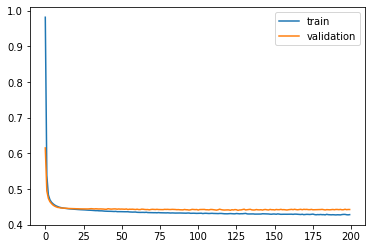

Entire process took:  199.64098954200745


In [11]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

num_per_fold = x_train.shape[0]//10
print(num_per_fold)

# CuDNNLSTM
units = 16
batch_s = 512
L2_1 = 0.00917304802367127
L2_2 = 1.0170384743005824e-07

# GRU
#units = 16
#batch_s = 1024
#L2_1 = 0.0055436321430643145
#L2_2 = 1.3792003444392802e-06
#L2_1 = 0.003493875946332654
#L2_2 = 1.5610118569518846e-06

# SimpleRNN#
#units = 16
#batch_s = 2048
#L2_1 = 0.007067191553394264
#L2_2 = 1.394048500868052e-08

start_time = time.time()

for f in range(3,4):#10
    #start = f*num_per_fold
    end = int((f+1)*num_per_fold)
    print("End:", end)
    train1_x = x_train[:end, ]
    train2_x = x_train[end:, ]
    train_x_lstm = np.append(train2_x, train1_x, axis=0) 
    train1_y = y_train[:end, ]
    train2_y = y_train[end:, ]
    train_y_lstm = np.append(train2_y, train1_y, axis=0)

    start_time_inner = time.time()
    #config = tf.ConfigProto(log_device_placement = True)
    #config.gpu_options.visible_device_list='1'
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):
        model = Sequential()
        model.add(CuDNNLSTM(units, #CuDNNLSTM
                                         kernel_regularizer=regularizers.l2(L2_1),
                                         input_shape=(8, 182)))
        model.add(RepeatVector(20))
        model.add(CuDNNLSTM(units, 
                            kernel_regularizer=regularizers.l2(L2_2),
                            return_sequences=True))
        model.add(TimeDistributed(Dense(1)))
        #adam = optimizers.Adam(lr=0.0015) #decay=1e-4
        #sgdm = optimizers.SGD(lr=0.001, momentum=0.9, decay=1e-7) 
        model.compile(loss='mae', optimizer='adam')#'adam'
        val_weight = "val_weights" + str(f+1) + ".hdf5"
        val_checkpointer = ModelCheckpoint(filepath=val_weight,
                                            monitor='val_loss', verbose=1,
                                            save_best_only=True)
        history = model.fit(train_x_lstm, train_y_lstm, batch_size=batch_s, 
                            epochs=200, validation_split=0.4, 
                            callbacks=[val_checkpointer], 
                            verbose=2, 
                            shuffle=False) 
        print("#################################")
        print("Number of units:", units)
        print("Batch size:", batch_s)
        print("L2_1:", L2_1)
        print("L2_2:", L2_2)
        print("best val loss:", min(history.history['val_loss']))
        print("#################################")
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='validation')
        pyplot.legend()
        pyplot.show()
        model.load_weights(val_weight)
        yhat_test = model.predict(x_test)
print("Entire process took: ", time.time() - start_time)

In [5]:
units = 16
L2_1 = 0.01
L2_2 = 1e-6
model = Sequential()
model.add(CuDNNLSTM(units, #CuDNNLSTM
                   kernel_regularizer=regularizers.l2(L2_1),
                   input_shape=(8, 182)))
model.add(RepeatVector(20))
model.add(CuDNNLSTM(units, 
                   kernel_regularizer=regularizers.l2(L2_2),
                   return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 16)                12800     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 20, 16)            0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 20, 16)            2176      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 1)             17        
Total params: 14,993
Trainable params: 14,993
Non-trainable params: 0
_________________________________________________________________


In [32]:
units = 16
model = Sequential()
model.add(CuDNNGRU(units, #CuDNNLSTM
                   kernel_regularizer=regularizers.l2(L2_1),
                   input_shape=(8, 182)))
model.add(RepeatVector(20))
model.add(CuDNNGRU(units, 
                   kernel_regularizer=regularizers.l2(L2_2),
                   return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_20 (CuDNNGRU)      (None, 16)                9600      
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 20, 16)            0         
_________________________________________________________________
cu_dnngru_21 (CuDNNGRU)      (None, 20, 16)            1632      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 20, 1)             17        
Total params: 11,249
Trainable params: 11,249
Non-trainable params: 0
_________________________________________________________________


In [12]:
print(yhat_test.shape)
print(scaled_test.shape[0]/28)
print(scaled_test.shape)
for i in range(scaled_test.shape[0]//28):
    scaled_test[((i*28)+8):((i+1)*28), 14] = yhat_test[i][:, 0]
inv_yhat = scaler.inverse_transform(scaled_test)
print("Inv yhat:", inv_yhat.shape)

(10096, 20, 1)
10096.0
(282688, 182)
Inv yhat: (282688, 182)


In [13]:
inv_yhat_df = pd.DataFrame(inv_yhat)
inv_yhat_df.columns = list(test_df.columns)[:-7]
#i = 0
#inv_yhat_df.iloc[(i*28):((i+1)*28), :]
feather.write_dataframe(inv_yhat_df, "/home/whsu014/data/TCHDL_LSTM_04val_yhat.feather")